## meterological data from DWD: German weather service  

1. data source: `sequential, hourly data from DWD`: German weather service and site in south berlin

2. features: 
- `prec_mm`- amount of precipitation (e.g. rain) in mm (normally scaled)
- `prec_bool`- boolean if precipitation (e.g. rain) (boolean)
- `humidity`- humidity (normally scaled)
- `temp`- temperature (normally scaled)
- `radiation`- solar radiation (normally scaled)
- `air_pressure`- (normally scaled)
- `wind_speed`- (normally scaled)
- `wind_degree`- (ordinary scaled) [1,360]



In [1]:
# load data
import pandas as pd

start_stamp = 2023010100 # define time period of 2023
end_stamp = 2023123199

# precipitation: rain_mm, prec_bool (raining or not)
precipitation = pd.read_csv('data/weather/hourly/433_precipitation_akt/00433.txt', sep= ';')
precipitation = precipitation.rename({'  R1':'prec_mm', 'RS_IND':'prec_bool', 'WRTR':'prec_type'}, axis= 1)
precipitation = precipitation[['MESS_DATUM', 'prec_mm', 'prec_bool', 'prec_type']]
precipitation = precipitation[(precipitation['MESS_DATUM']>= start_stamp)& (precipitation['MESS_DATUM']<end_stamp)]

# temperature: humidity, temp
temp = pd.read_csv('data/weather/hourly/433_temp_akt/00433.txt', sep= ';')
temp = temp.rename({'RF_TU':'humidity', 'TT_TU':'temp'}, axis= 1)
temp = temp[['humidity', 'temp', 'MESS_DATUM']]
temp = temp[(temp['MESS_DATUM']>= start_stamp)& (temp['MESS_DATUM']<end_stamp)]

# radiation: radiation
radiation = pd.read_csv('data/weather/hourly/3987_radiation_potsdam/03987.txt', sep= ';')
radiation['MESS_DATUM'] = radiation['MESS_DATUM_WOZ'].apply(lambda x: int(x[:-3]))
radiation = radiation.rename({'FG_LBERG':'radiation'}, axis= 1)
radiation = radiation[['MESS_DATUM', 'radiation']]
radiation = radiation[(radiation['MESS_DATUM']>= start_stamp)& (radiation['MESS_DATUM']<end_stamp)]

# air pressure
pressure = pd.read_csv('data/weather/hourly/433_pressure_akt/00433.txt', sep= ';')
pressure = pressure.rename({'   P':'air_pressure'}, axis= 1)
pressure = pressure[['air_pressure', 'MESS_DATUM']]
pressure = pressure[(pressure['MESS_DATUM']>= start_stamp)& (pressure['MESS_DATUM']<end_stamp)]

# wind: wind_degree [0, 360], wind_speed
wind = pd.read_csv('data/weather/hourly/433_wind/00433.txt', sep= ';')
wind = wind.rename({'   D':'wind_degree', '   F':'wind_speed'}, axis= 1)
wind = wind[['wind_degree', 'wind_speed', 'MESS_DATUM']]
wind = wind[(wind['MESS_DATUM']>= start_stamp)& (wind['MESS_DATUM']<end_stamp)]

# merge all weather features
df_weather = pd.merge(precipitation, temp, on= 'MESS_DATUM')
df_weather = pd.merge(df_weather, radiation, on= 'MESS_DATUM')
df_weather = pd.merge(df_weather, wind, on= 'MESS_DATUM', how= 'outer')
df_weather = pd.merge(df_weather, pressure, on= 'MESS_DATUM', how= 'outer')

float_feature = ['prec_mm', 'humidity', 'temp', 'radiation', 'wind_speed', 'air_pressure']

df_weather = df_weather.replace(-999.0, None) # insert na values
df_weather[float_feature] = df_weather[float_feature].astype('float') # adjust datatype
df_weather['wind_degree'] = df_weather['wind_degree'].astype('object') # adjust datatype

df_weather.to_csv('data/weather/hourly/hourly_weather.csv') # save dataframe
df_weather.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MESS_DATUM    8760 non-null   int64  
 1   prec_mm       8662 non-null   float64
 2   prec_bool     8662 non-null   object 
 3   prec_type     8735 non-null   object 
 4   humidity      8753 non-null   float64
 5   temp          8755 non-null   float64
 6   radiation     8720 non-null   float64
 7   wind_degree   8748 non-null   object 
 8   wind_speed    8745 non-null   float64
 9   air_pressure  8755 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 684.5+ KB


## EDA on Missing DATA

In [2]:
# check for missing data
print('N missing data per feature:')
df_weather.isna().sum()

N missing data per feature:


MESS_DATUM       0
prec_mm         98
prec_bool       98
prec_type       25
humidity         7
temp             5
radiation       40
wind_degree     12
wind_speed      15
air_pressure     5
dtype: int64

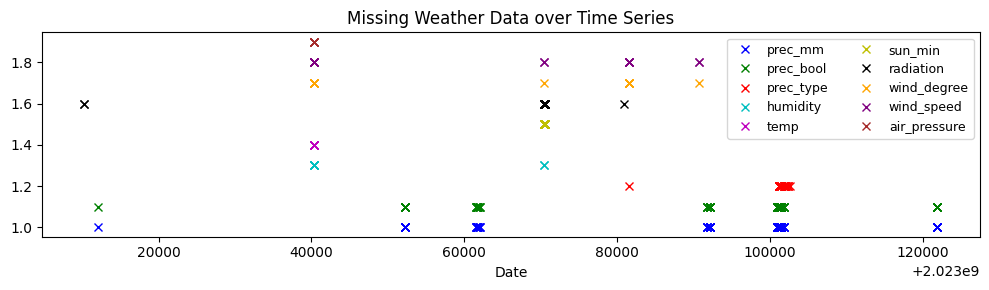

In [3]:
# plot missing data over time
import matplotlib.pyplot as plt

features = df_weather.columns[1:]
colors = ['b','g','r','c','m','y','k','orange','purple','brown','pink']

plt.figure(figsize=(10, 3)) 

for n in range(len(features)):
    current_missing = df_weather[df_weather[features[n]].isna()]['MESS_DATUM']
    missing_series = pd.Series([1] * len(current_missing), index=current_missing)
    plt.plot(missing_series.index, missing_series.values + (n*0.1), 'x', label=features[n], color = colors[n])

plt.xlabel('Date')
plt.title('Missing Weather Data over Time Series')
plt.legend(loc= 'upper right', fontsize = 9, ncols = 2 )
plt.tight_layout()
plt.savefig('data/output/imputation/Missing_Weather_over_time.png', dpi = 180)
plt.show()

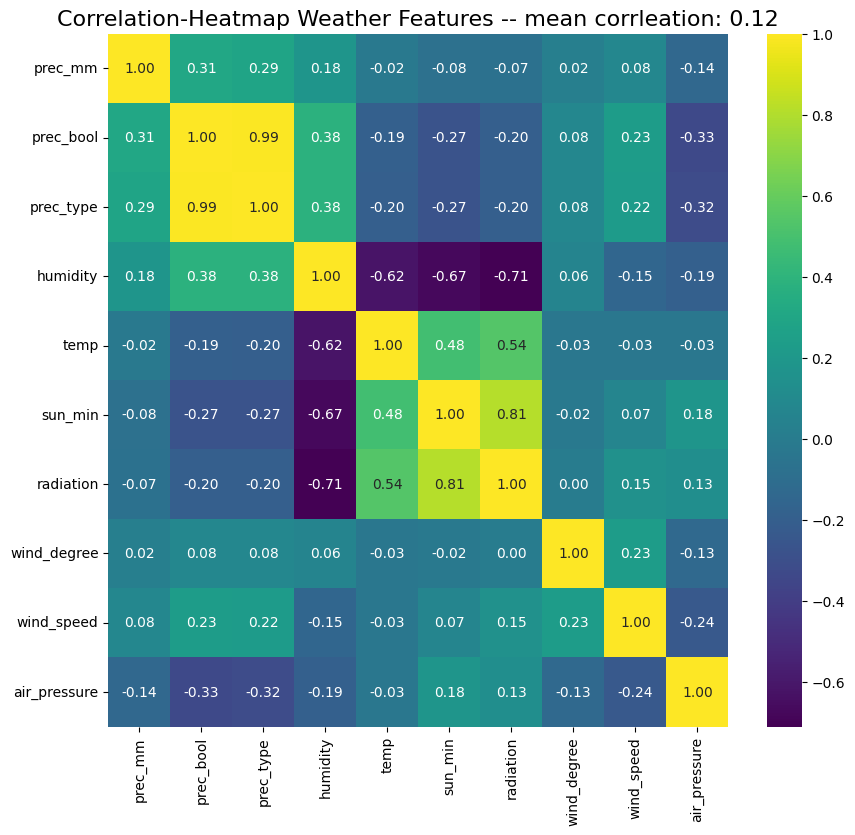

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr


def feature_correlation(df, features, name):

    df_no_na = df.dropna() # remove rows with na for correlation test
    
    # initialize and fill heatmap
    matrix = np.zeros((len(features), len(features))) 

    for i, feature1 in enumerate(features):
        for j, feature2 in enumerate(features):
            matrix[i, j] = round(pearsonr(df_no_na[feature1], df_no_na[feature2])[0],2) # correlation test 

    # Create a heatmap using seaborn
    plt.figure(figsize=(10, 9))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap='viridis',
                xticklabels=features, yticklabels=features)
    plt.title(f'{name} -- mean corrleation: {round(matrix.mean(),2)}', size = 16)
    plt.savefig(f"data/output/imputation/{name.replace(' ','_')}.png", dpi = 180)
    plt.show()

feature_correlation(df = df_weather, 
                    features = list(df_weather.columns.drop(['MESS_DATUM', 'direc'])), 
                    name = 'Correlation-Heatmap Weather Features')


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#time depend correlation in absence between two features

def prop_missing_together(feature1, feature2):
    missing_1 = list(df_weather[df_weather[feature1].isna()]['MESS_DATUM'])
    missing_2 = list(df_weather[df_weather[feature2].isna()]['MESS_DATUM'])

    not_missing_together = []

    for datapoint in missing_1:
        if datapoint not in missing_2:
            not_missing_together.append(datapoint)

    for datapoint in missing_2:
        if datapoint not in missing_1:
            not_missing_together.append(datapoint)

    not_missing_together = round(len(not_missing_together)/(len(missing_1)+len(missing_2)),3)
    return 1 -not_missing_together

def plot_pro_na_together(features):
# heatmap
    
    matrix = np.zeros((len(features), len(features))) # initalize matrix

    for i, feature1 in enumerate(features):
        for j, feature2 in enumerate(features):
            matrix[i, j] = prop_missing_together(feature1, feature2)

    # Create a heatmap using seaborn
    plt.figure(figsize=(10, 9))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap='viridis',
                xticklabels=features, yticklabels=features)
    plt.title('Heatmap of Proportion of Missing Values Together', size = 14)
    plt.savefig(f"data/output/imputation/Heatmap_Proportion_of_NA_Together.png", dpi = 180)
    plt.show()


plot_pro_na_together(features = list(df_weather.columns.drop(['MESS_DATUM', 'direc'])))

In [151]:
# find number of features missing at same time stamp

na_series_list = []
na_series_dict = {}

for n in range(len(df_weather)):
    if df_weather.loc[n].isna().sum() > 0:
        na_series_list.append(df_weather.loc[n].isna().sum())

for n in range(1, max(na_series_list) +1 ):
    na_series_dict[n] = na_series_list.count(n)

print('nuber of features missing at same time stamp')
na_series_dict

nuber of features missing at same time stamp


{1: 67, 2: 55, 3: 2, 4: 0, 5: 5}

In [9]:
def len_series_missing(df, features, index_parameter):
    
    series_missing_dict = {}


    for feature in df[features]:

        # initialize list to store the number of directly following missing values for current feature
        current_series_list = []
        # list of index (time stamp) for missing value
        index_missing_list = list(df_weather[df_weather[feature].isna()][index_parameter])
        # 
        
        count = 1
        for n in range(1, len(index_missing_list)):
            
            if index_missing_list[n-1] + 1 == index_missing_list[n]:
                count += 1
            else:
                current_series_list.append(count)
                count = 1
        
        current_series_list.append(count)

        current_series_list.sort(reverse= True)
        series_missing_dict[feature] = current_series_list
        
    return series_missing_dict

series_missing_dict = len_series_missing(df= df_weather,
                                         features = list(df_weather.columns.drop('MESS_DATUM')),
                                         index_parameter = 'MESS_DATUM'
                                         )

print('Table: Features and sequence length of consecutive (in sequence) missing data')
series_missing_dict

Table: Features and sequence length of consecutive (in sequence) missing data


{'prec_mm': [10, 8, 7, 6, 6, 4, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2],
 'prec_bool': [7, 4, 3, 1],
 'humidity': [4, 2],
 'temp': [4],
 'sun_min': [18, 12, 7],
 'radiation': [18, 12, 7, 2],
 'wind_degree': [5, 5, 1, 1],
 'wind_speed': [5, 5, 2, 2],
 'air_pressure': [4]}

## Imputation of missind data
1. through correlation
2. linear imputation for single missing values
3. rest: adhanced

### imputation through correlation (N imputations = 84 values)
- prec_bool and pre_type are highly correlated in values but not in absence

- > prec_boo takes 0 (no rain) if prec_bool == 0 (type no rain)
- > prec_boo takes 1 (rain) if prec_bool >= 0 (other type of precipitation)


In [4]:
# impute values based on strong correlation in prec_bool and prec_type

for n in range(len(df_weather)):
    if pd.isna(df_weather['prec_bool'][n]) == True: # if value in prec_bool is na
        if pd.isna(df_weather['prec_type'][n]) == False: # if value for prec_type at same index is not na
            # if type ==  no rain or >= 50 minutes sun in the hour
            if df_weather['prec_type'][n] == 0: 
                df_weather.loc[n, 'prec_bool'] = 0 # impute 0 for no rain 
                df_weather.loc[n, 'prec_mm'] = 0
            
            else: # for other type of precipitation 
                df_weather.loc[n, 'prec_bool'] = 1 

df_weather = df_weather.drop('prec_type', axis= 1)

### linear interpolation of missing single values (N =12)
1. select only ordinal scaled numeric weather variables 
2. identify single (non clustered) missing values (value before and following exist)
3. plot those values
3. impute values through linear interpolation

In [5]:
features = ['prec_mm', 'humidity', 'temp',  'radiation', 'wind_speed', 'air_pressure', 'wind_degree'] 

# single missing point (time series measure exist before and after)
def find_single_missing_pints(list_missing_vlaues):
    single_missing_pints = []
    for missing_datapoint in list_missing_vlaues:
        if missing_datapoint -1 not in list_missing_vlaues and missing_datapoint +1 not in list_missing_vlaues:
            single_missing_pints.append(missing_datapoint)
    
    return single_missing_pints


def linear_interpolation(feature, time_stamp):
    
    # before value 
    before_value = int(df_weather[df_weather['MESS_DATUM'] == time_stamp-1][feature])
    # following value
    after_value = int(df_weather[df_weather['MESS_DATUM'] == time_stamp+1][feature])
    # impute value 
    interpolated_value = (before_value + after_value)/2
    col_indexer = df_weather[df_weather['MESS_DATUM'] == time_stamp][feature].index[0]
    print(f'{interpolated_value} for {feature} at {time_stamp}')
    df_weather.loc[col_indexer, feature] = interpolated_value                 

# interpolate those missing values
for n in range(len(features)):
    current_missing = df_weather[df_weather[features[n]].isna()]['MESS_DATUM']
    single_missing = find_single_missing_pints(list(current_missing))

    for missing in single_missing:
        linear_interpolation(feature= features[n], time_stamp = missing)
                        

0.0 for prec_mm at 2023012116
0.0 for prec_mm at 2023052307
0.5 for prec_mm at 2023062010
0.0 for prec_mm at 2023062103
0.0 for prec_mm at 2023092214
0.0 for prec_mm at 2023101018
0.0 for prec_mm at 2023101401
54.5 for humidity at 2023040311
3.5 for temp at 2023040311
205.0 for radiation at 2023080910
5.0 for wind_speed at 2023040312
1032.0 for air_pressure at 2023040311
255.0 for wind_degree at 2023070412
110.0 for wind_degree at 2023090712


C:\Users\Richard\AppData\Local\Temp\ipykernel_13756\4257689089.py:16: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  before_value = int(df_weather[df_weather['MESS_DATUM'] == time_stamp-1][feature])
C:\Users\Richard\AppData\Local\Temp\ipykernel_13756\4257689089.py:18: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  after_value = int(df_weather[df_weather['MESS_DATUM'] == time_stamp+1][feature])
C:\Users\Richard\AppData\Local\Temp\ipykernel_13756\4257689089.py:16: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  before_value = int(df_weather[df_weather['MESS_DATUM'] == time_stamp-1][feature])
C:\Users\Richard\AppData\Local\Temp\ipykernel_13756\4257689089.py:18: FutureWarning: Calling int on a single element Serie

In [ ]:

import matplotlib.pyplot as plt
features = ['prec_mm', 'humidity', 'temp', 'radiation', 'wind_speed', 'air_pressure'] 
colors = ['b','g','r','c','m','y','k']
plt.figure(figsize=(10, 3)) 

for n in range(len(features)):
    current_missing = df_weather[df_weather[features[n]].isna()]['MESS_DATUM']
    single_missing = find_single_missing_pints(list(current_missing))
    missing_series = pd.Series([1] * len(single_missing), index=single_missing)
    plt.plot(missing_series.index, missing_series.values + (n*0.1), 'x', label=features[n], color = colors[n])

plt.xlabel('Date')
plt.title('Single Missing Weather Data Points over Time Series')
plt.legend(loc= 'upper right', fontsize = 9, ncols = 2 )
plt.tight_layout()
plt.show()

In [5]:
# check for missing data
print('N missing data per feature:')
df_weather.isna().sum()

N missing data per feature:


MESS_DATUM       0
prec_mm         77
prec_bool       15
humidity         6
temp             4
sun_min         37
radiation       39
wind_degree     10
wind_speed      14
air_pressure     4
dtype: int64

## multi-step fore casting

### impute values using univariate multi- step forecasting
1. training LSTM: load data of previous years and select time span without missing values
2. define LSTM model and required data transformation: 10,896 instances = [(454,24,1)] - [(samples, timesteps,features)]
3. fit model

In [6]:
# read data
import pandas as pd
df_weather_train = pd.read_csv('data/weather/hourly/history/df_weather_train.csv')

In [7]:
# initalize model for training 
from keras import Sequential
from keras.layers import LSTM, Dense

# function to reshape 
def reshape_data(data, timesteps):
    train = np.array(np.split(data, len(data)/timesteps), dtype= 'float')
    train = train.reshape(train.shape[0], train.shape[1], 1)
    return train


def to_supervised(train, timesteps, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + timesteps
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
		
	return np.array(X, dtype= 'float'), np.array(y, dtype= 'float')


def build_model_lstm(train, timesteps, verbose = 0, epochs= 10, batch_size= 32):
	# prepare data
	train_x, train_y = to_supervised(train, timesteps, n_out = timesteps)
	# define parameters
	
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mae', optimizer='adam')
	
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split= 0.2)
	return model


def train_uni_LSTM(df, feature, timesteps, verbose = 0, epochs= 10, batch_size= 32):
	train = reshape_data(df[feature].values, timesteps= timesteps)
	model = build_model_lstm(train, timesteps= timesteps,
					     	 verbose = verbose, epochs = epochs, batch_size= batch_size)
	print(f'finish training lstm for {feature}')
	return model

#train_uni_CNN_LSTM(df = df_weather_train, feature = 'temp', timesteps = 24, verbose = 1, epochs= 10, batch_size= 48)

C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
import numpy as np
def impute_with_LSTM(index, model, df, feature ):
    
    # define and reshape input data (previous 24 steps)
    input_data = np.array(df[feature][index[0] - 24:index[0]], dtype= 'float').reshape(1,24,1)
    # predict based on pretrained model & select only relevant number
    predicted = (model.predict(input_data, verbose=0).tolist()[0])[:len(index)]
    # place values in dataframe
    for n in range(len(index)):
        df.loc[index[n], feature] = round(predicted[n],2)
    
    return df

# initialize and train model on feature weather data of previous years

for feature in ['prec_mm', 'humidity', 'temp', 'radiation']:
    # train model on feature and training data
    model = train_uni_LSTM(df = df_weather_train, feature = feature, timesteps = 24, verbose = 0, epochs= 5, batch_size= 32) 

    current_df = df_weather[df_weather[feature].isna()].filter(['MESS_DATUM']).reset_index()

    # iterate over missing data
    index = [current_df.iloc[0]['index']]
    for n in range(1, len(current_df)):
        if int(current_df.iloc[n]['index']) == index[-1] +1:
            index.append(current_df.iloc[n]['index'])
        else:
            # apply imputation
            impute_with_LSTM(index, model = model, df = df_weather, feature = feature)
            index = [current_df.iloc[n]['index']]
        
    impute_with_LSTM(index, model = model, df = df_weather, feature = feature)


C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


finish training lstm for prec_mm


C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


finish training lstm for humidity


C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


finish training lstm for temp


C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


finish training lstm for radiation


In [10]:
df_weather.isna().sum()

MESS_DATUM       0
prec_mm          0
prec_bool       15
humidity         0
temp             0
radiation        0
wind_degree     10
wind_speed      14
air_pressure     4
dtype: int64

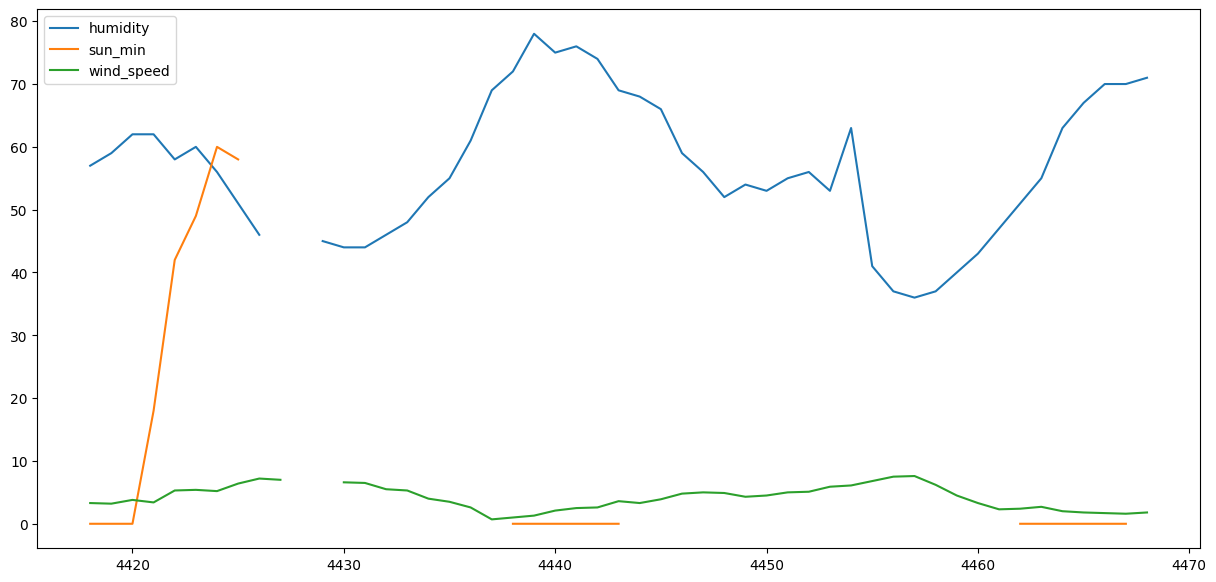

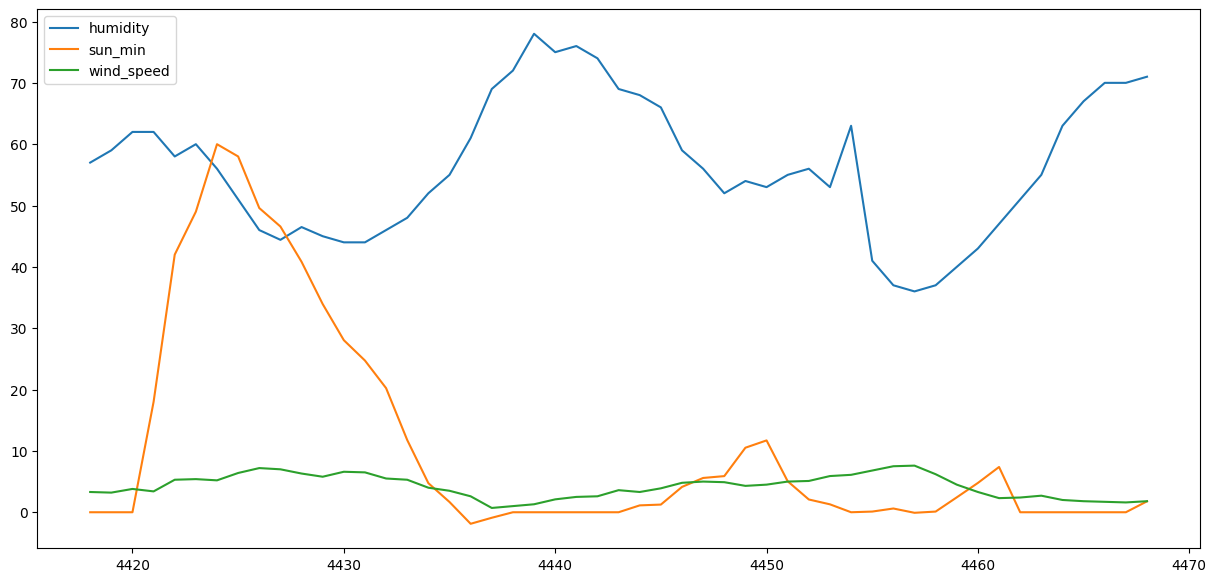

In [62]:
# plot example
import matplotlib.pyplot as plt

start_date = 2023070401
end_date = 2023070605

example_missing = df_weather[(df_weather['MESS_DATUM'] > start_date) & (df_weather['MESS_DATUM'] < end_date)]

example_missing_imputed= df_weather[(df_weather['MESS_DATUM'] > start_date) & (df_weather['MESS_DATUM'] < end_date)]

plt.figure(figsize=(15, 7)) 
plt.plot(example_missing[['humidity', 'radiation', 'wind_speed']], label = ['humidity', 'radiation', 'wind_speed'])
plt.legend()
plt.show()
plt.figure(figsize=(15, 7)) 
plt.plot(example_missing_imputed[['humidity', 'radiation',  'wind_speed']], label = ['humidity', 'radiation',  'wind_speed'])
plt.legend()
plt.show()



### linear iterpolate features with lower score on LSTM

In [11]:
# linear interpolate wind speed & air pressure
df_weather[[ 'wind_speed', 'air_pressure']] = df_weather[[ 'wind_speed', 'air_pressure']].interpolate(method = 'linear')

### imputation categgorical values
prec_bool
wind_degree

In [13]:
# simple forward fill bool
df_weather[['prec_bool', 'wind_degree']] = df_weather[['prec_bool', 'wind_degree']].astype('float').ffill()

In [96]:
# NOT IN USE!
# wind degree
# assign categorical value to wind direction in degree

def assign_dirct(degree):
    if degree < 22.5 or degree > 360-22.5:
        return 'N'
    if degree > 22.5 and degree < 45 +22.5:
        return 'NO'
    if degree > 45 +22.5 and degree < 90 +22.5:
        return 'O'
    if degree > 90 +22.5 and degree < 135+22.5:
        return 'SO'
    if degree > 135 +22.5 and degree < 180+22.5:
        return 'S'
    if degree > 180 +22.5 and degree < 225+22.5:
        return 'SW'
    if degree > 225 +22.5 and degree < 270+22.5:
        return 'W'
    if degree > 270 +22.5 and degree < 315+22.5:
        return 'NW'
    else:
        return 'fail'

df_weather['wind_direction'] = df_weather['wind_degree'].apply(lambda x: assign_dirct(x))
df_weather = df_weather.drop('wind_degree', axis= 1) 
df_weather['wind_direction'] = df_weather['wind_direction'].ffill()

In [14]:
df_weather.to_csv('data/weather/df_weather_cleaned.csv')
df_weather.isna().sum()

MESS_DATUM      0
prec_mm         0
prec_bool       0
humidity        0
temp            0
radiation       0
wind_degree     0
wind_speed      0
air_pressure    0
dtype: int64